In [1]:
!git branch
!git checkout TFT
!git branch

* TFT
  main
M	TFT/Residential/TFT_CNI.ipynb
Your branch is ahead of 'origin/TFT' by 2 commits.
  (use "git push" to publish your local commits)


Already on 'TFT'


* TFT
  main


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from torch.nn import MSELoss
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# Weather Dataset

In [4]:
electricity_consumption = pd.read_csv("../../ProcessedData/Electricity-ResBusClimateUNI.csv")
electricity_consumption

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh),Export prices,Export volumes,Export values,Import prices,Import volumes,Import values,Population
0,2010-01-01,41.90,20.05,17.40,4.20,11.0,1.70,2010.0,1.0,572.918,282.000,1072.0,1160.0,10093.0,904.0,1360.0,8827.0,1600200.0
1,2010-02-01,34.80,21.35,19.70,3.65,8.0,1.20,2010.0,2.0,564.809,259.792,1072.0,1160.0,10093.0,904.0,1360.0,8827.0,1600200.0
2,2010-03-01,7.60,19.30,16.65,4.35,12.5,1.45,2010.0,3.0,621.988,295.270,1072.0,1160.0,10093.0,904.0,1360.0,8827.0,1600200.0
3,2010-04-01,48.40,17.05,16.05,3.15,7.0,1.40,2010.0,4.0,573.259,303.576,1112.0,1264.0,11416.0,920.0,1476.0,9740.0,1600200.0
4,2010-05-01,197.50,14.60,14.40,3.55,12.5,1.95,2010.0,5.0,608.594,363.480,1112.0,1264.0,11416.0,920.0,1476.0,9740.0,1600200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2024-02-01,43.80,20.35,17.85,3.70,3.5,1.30,2024.0,2.0,574.003,311.724,1362.0,1465.0,16196.0,998.0,2381.0,17050.0,1943200.0
170,2024-03-01,55.65,17.90,15.60,4.10,10.5,2.10,2024.0,3.0,581.185,337.730,1362.0,1465.0,16196.0,998.0,2381.0,17050.0,1943200.0
171,2024-04-01,81.95,16.95,15.95,3.65,8.0,1.80,2024.0,4.0,555.173,348.859,1433.0,1584.0,18433.0,1029.0,2414.0,17823.0,1943200.0
172,2024-05-01,115.75,13.35,12.80,3.75,11.5,1.75,2024.0,5.0,593.491,452.473,1433.0,1584.0,18433.0,1029.0,2414.0,17823.0,1943200.0


In [5]:
# Convert dataframe to Timeseries
ts = TimeSeries.from_dataframe(electricity_consumption, time_col="Date" )

In [6]:
# training and validation split
training_cutoff = pd.Timestamp('2021-01-01')
train, val = ts.split_before(training_cutoff)

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
transformer = Scaler(scaler)
transformer_target = Scaler(scaler)

train_target_og = train['Est. Total consumption (GWh)']
val_target_og = val['Est. Total consumption (GWh)']
train_target = transformer_target.fit_transform(train_target_og)
val_target = transformer_target.transform(val_target_og)

train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(ts)

#split past covariates
train_past_cov = train_transformed[
    [ 
        'Mean Air Temperature in Celsius', 
        'Mean Vapour Pressure Hpa',
        'Days Of Wind Gust >= 24 Knots in Day'
    ]
]

# replace missing value with the mean of column
train_past_cov = train_past_cov.pd_dataframe()
train_past_cov = train_past_cov.apply(lambda col: col.fillna(col.mean()))
train_past_cov = TimeSeries.from_dataframe(train_past_cov)

In [8]:
series_transformed = series_transformed.pd_dataframe()
series_transformed = series_transformed.apply(lambda col: col.fillna(col.mean()))
series_transformed = TimeSeries.from_dataframe(series_transformed)

# Model Training Forecasting

In [26]:
# with past covariates
input_chunk_length = 72
forecast_horizon = 42

my_model_withpast = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=100,
    lstm_layers=3,
    num_attention_heads=3,
    dropout=0.1,
    batch_size=30,
    n_epochs=150,
    add_relative_index=False,
    add_encoders={
        'cyclic': {'past': ['month']},  
        'datetime_attribute': {'future': ['month', 'year']},
    },
    loss_fn=MSELoss(),
    likelihood=None,
    random_state=5,
)
my_model_withpast.fit(train_target, past_covariates = train_past_cov, verbose=True)

Training: |                                                                                      | 0/? [00:00<…

TFTModel(output_chunk_shift=0, hidden_size=100, lstm_layers=3, num_attention_heads=3, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=MSELoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=72, output_chunk_length=42, batch_size=30, n_epochs=150, add_encoders={'cyclic': {'past': ['month']}, 'datetime_attribute': {'future': ['month', 'year']}}, random_state=5)

In [27]:
# without past covariates
input_chunk_length = 72
forecast_horizon = 42

my_model_nopast = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=100,
    lstm_layers=3,
    num_attention_heads=3,
    dropout=0.1,
    batch_size=30,
    n_epochs=150,
    add_relative_index=False,
    add_encoders={
        'cyclic': {'past': ['month']},  
        'datetime_attribute': {'future': ['month', 'year']},
    },
    loss_fn=MSELoss(),
    likelihood=None,
    random_state=5,
)

my_model_nopast.fit(train_target, verbose=True)

Training: |                                                                                      | 0/? [00:00<…

TFTModel(output_chunk_shift=0, hidden_size=100, lstm_layers=3, num_attention_heads=3, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=MSELoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=72, output_chunk_length=42, batch_size=30, n_epochs=150, add_encoders={'cyclic': {'past': ['month']}, 'datetime_attribute': {'future': ['month', 'year']}}, random_state=5)

In [12]:
from darts.metrics import mape, mae, rmse

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

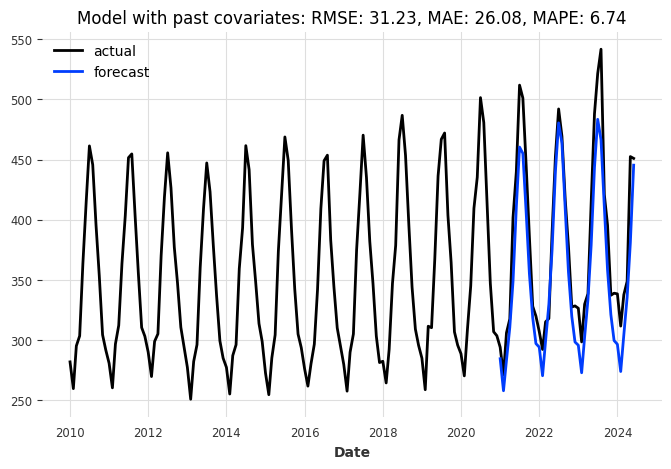

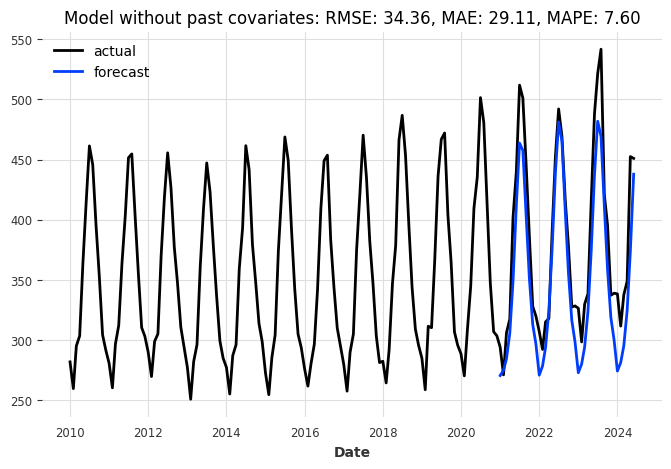

In [30]:
def eval_model(model, num):
    pred_series = model.predict(n=42)
    plt.figure(figsize=(8, 5))
    pred_series_reversed = transformer_target.inverse_transform(pred_series)
    ts['Est. Total consumption (GWh)'].plot(label="actual")
    pred_series_reversed['Est. Total consumption (GWh)'].plot(label="forecast")
    if num == 1:
        plt.title("Model with past covariates: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target_og, pred_series_reversed), mae(val_target_og, pred_series_reversed), mape(val_target_og, pred_series_reversed)))
        plt.legend()
        return pred_series
    else:
        plt.title("Model without past covariates: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target_og, pred_series_reversed), mae(val_target_og, pred_series_reversed), mape(val_target_og, pred_series_reversed)))
        plt.legend()
        return pred_series

pred_series_transformed = eval_model(my_model_withpast, 1)
pred_series_transformed_no_past_cov = eval_model(my_model_nopast, 0)

# Backtesting

In [9]:
model_TFT_backtest = TFTModel(
    input_chunk_length=66,
    output_chunk_length=3,
    hidden_size=100,
    lstm_layers=3,
    num_attention_heads=3,
    dropout=0.1,
    batch_size=30,
    n_epochs=100,
    add_relative_index=False,
    add_encoders={
        'cyclic': {'past': ['month']},  
        'datetime_attribute': {'future': ['month', 'year']},
    },
    loss_fn=MSELoss(),
    likelihood=None,
    random_state=5,
)


Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

NameError: name 'rmse' is not defined

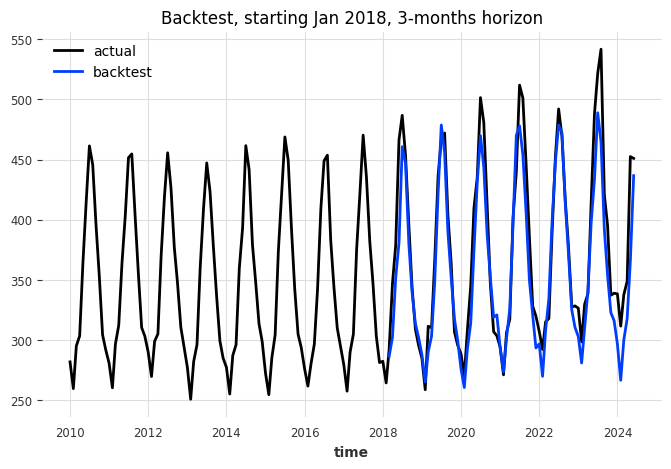

In [11]:
# with past covariates
backtest_series_with = model_TFT_backtest.historical_forecasts(
    series_transformed['Est. Total consumption (GWh)'],               
    past_covariates=series_transformed[['Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa', 'Days Of Wind Gust >= 24 Knots in Day']],   
    start=pd.Timestamp("20180101"),
    forecast_horizon=3,
    retrain=True,
    verbose=False,
)

backtest_series_reversed_with = transformer_target.inverse_transform(backtest_series_with)



MAPE: 5.29%, RMSE: 27.50


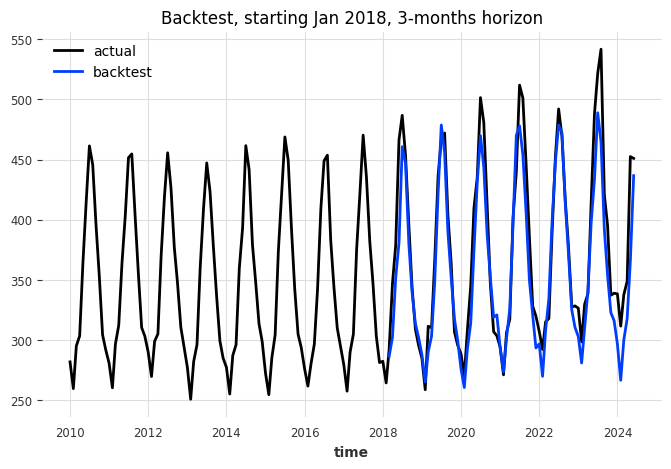

In [13]:
plt.figure(figsize=(8, 5))
ts['Est. Total consumption (GWh)'].plot(label="actual")
backtest_series_reversed_with.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2018, 3-months horizon")
print(
    "MAPE: {:.2f}%, RMSE: {:.2f}".format(
        mape(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed_with,
        ),
        rmse(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed_with,
        )
    )
)

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

MAPE: 5.88%, RMSE: 27.69


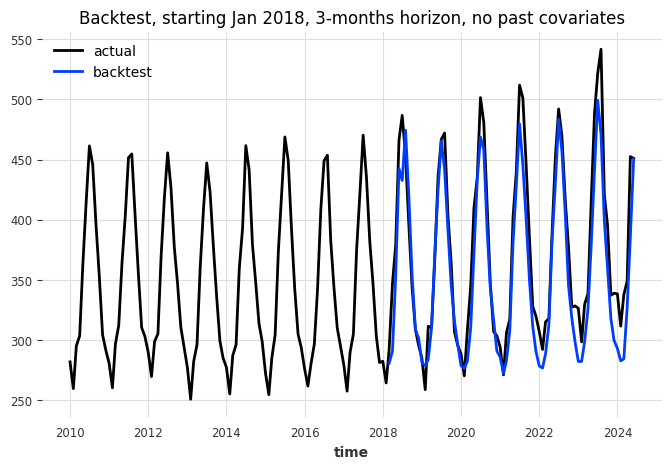

In [14]:
# without past covariates
backtest_series_without = model_TFT_backtest.historical_forecasts(
    series_transformed['Est. Total consumption (GWh)'],
    start=pd.Timestamp("20180101"),
    forecast_horizon=3,
    retrain=True,
    verbose=False,
)

backtest_series_reversed_without = transformer_target.inverse_transform(backtest_series_without)

plt.figure(figsize=(8, 5))
ts['Est. Total consumption (GWh)'].plot(label="actual")
backtest_series_reversed_without.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2018, 3-months horizon, no past covariates")
print(
    "MAPE: {:.2f}%, RMSE: {:.2f}".format(
        mape(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed_without,
        ),
        rmse(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed_without,
        )
    )
)

In [15]:
# Assuming 'backtest_series_reversed' is already available and converted to pandas DataFrame
backtest_series_df = backtest_series_reversed_with.pd_dataframe()

# Save the DataFrame to a CSV file
csv_file_path = './Result_res/TFT/UNI/res.csv'
backtest_series_df.to_csv(csv_file_path)

csv_file_path

'./Result_res/TFT/UNI/res.csv'

C:\Users\unknow\AppData\Local\Temp\ipykernel_10584\3875208016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data.rename(columns={'Date': 'time', 'Est. Total consumption (GWh)': 'actual'}, inplace=True)


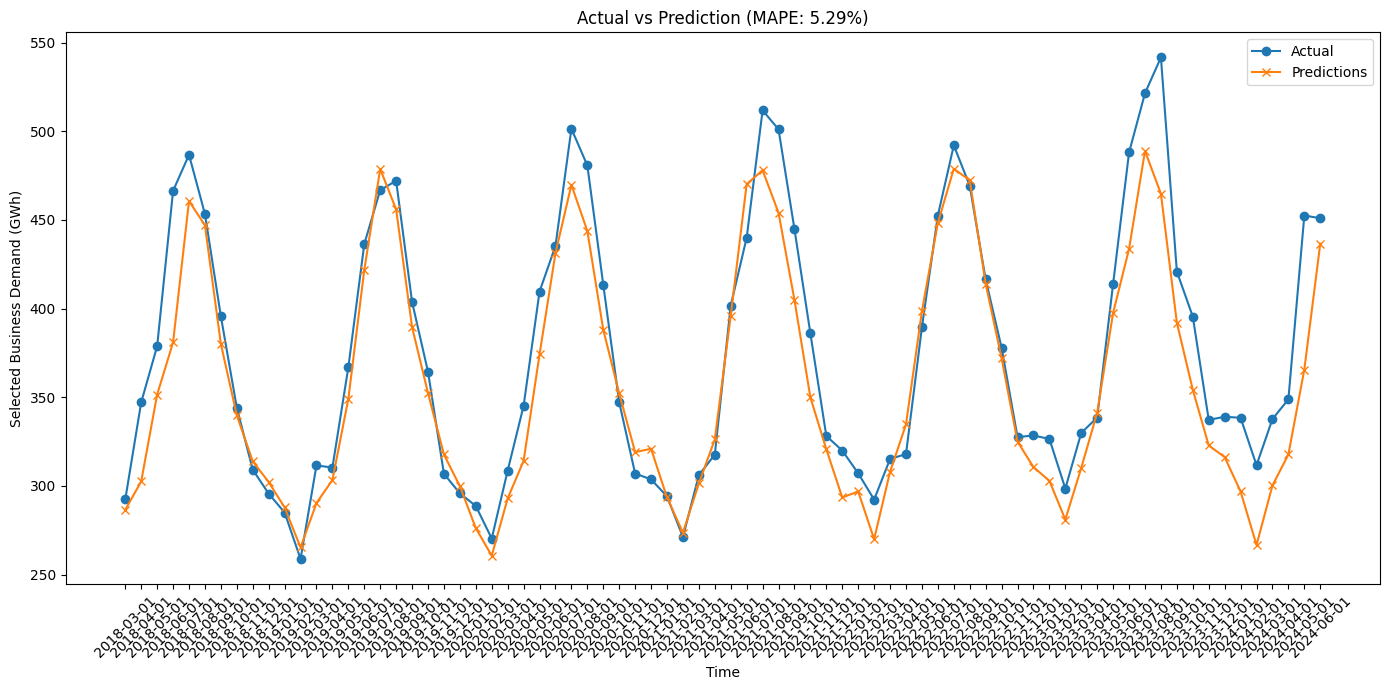

In [1]:
import pandas as pd

def generate_comparison_csv(prediction_file_path, output_file_path):
    # 加载原始数据文件，提取 'Selected business demand (GWh)' 列
    original_file_path = '../../../ProcessedData/Electricity-ResBusClimateUNI.csv'
    original_data = pd.read_csv(original_file_path)
    
    # 提取 'Date' 和 'Selected business demand (GWh)' 列，并重命名以匹配预测数据格式
    selected_data = original_data[['Date', 'Est. Total consumption (GWh)']]
    selected_data.rename(columns={'Date': 'time', 'Est. Total consumption (GWh)': 'actual'}, inplace=True)

    # 加载预测数据
    prediction_data = pd.read_csv(prediction_file_path)
    
    # 合并预测数据和实际值数据，基于 'time' 列
    merged_data = pd.merge(prediction_data, selected_data, on='time', how='inner')
    
    # 计算预测值和实际值之间的差异
    merged_data['difference'] = merged_data['Est. Total consumption (GWh)'] - merged_data['actual']
    
    # 重命名预测列为 'prediction'
    merged_data.rename(columns={'Est. Total consumption (GWh)': 'predictions'}, inplace=True)
    
    # 选择最终的列：time, prediction, actual, difference
    final_data = merged_data[['time', 'predictions', 'actual', 'difference']]
    
    # 保存最终数据到指定的 CSV 文件
    final_data.to_csv(output_file_path, index=False)
    
    return output_file_path

prediction_path = '../../../Result/Result_res/TFT_covariate.UNI.res.csv'
output_path = '../../../Result/Result_res/TFT_covariate.UNI.res.csv'
generate_comparison_csv(prediction_path, output_file_path=output_path)

import pandas as pd
import matplotlib.pyplot as plt

# 加载已经包含4列的CSV文件
file_path = '../../../Result/Result_res/TFT_covariate.UNI.res.csv'
data = pd.read_csv(file_path)

# 计算MAPE (Mean Absolute Percentage Error)
data['mape'] = abs((data['actual'] - data['predictions']) / data['actual']) * 100
mape = data['mape'].mean()

# 绘制实际值和预测值的折线图
plt.figure(figsize=(14, 7))
plt.plot(data['time'], data['actual'], label='Actual', marker='o')
plt.plot(data['time'], data['predictions'], label='Predictions', marker='x')
plt.xlabel('Time')
plt.ylabel('Selected Business Demand (GWh)')
plt.title(f'Actual vs Prediction (MAPE: {mape:.2f}%)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
